In [203]:
from zget_data import get_responses, get_qdetails, get_qinfo, get_questions, page_map, quest_map
from collections import defaultdict
import pandas as pd
import json
import matplotlib.pyplot as plt

In [204]:
survey_response, time_response = get_responses()

# Time Analysis

,index,1,2,3,4,5,6,7,csquest,spasssurvey,demo,total (mins)
0,47.704,8.317,5.774,20.529,3.303,35.736,6.323,62.769,1143.746,75.336,75.957,24.758233
1,94.517,1.465,1.784,2.418,1.715,2.317,1.786,2.398,512.819,53.485,0.000,11.245067
2,46.771,12.130,4.182,102.546,5.296,64.259,3.211,9.071,773.980,353.297,110.543,24.754767
3,112.525,18.469,4.349,164.076,5.031,33.316,3.948,68.685,1014.168,145.120,280.664,30.839183
4,4636.935,1.935,1.335,3.205,1.451,2.301,1.433,2.999,337.065,102.016,175.999,87.777900
5,105.025,16.754,7.482,129.686,5.546,36.542,4.964,47.761,932.582,116.456,236.687,27.324750
6,47.143,11.761,2.208,47.459,2.428,85.477,2.790,14.028,686.124,65.725,134.659,18.330033
7,99.858,14.159,2.956,53.905,2.561,63.889,2.582,11.184,774.233,51.635,113.305,19.837783
8,124.060,12.710,1.925,32.439,3.274,72.685,2.437,11.451,932.020,141.502,269.218,26.728683
9,104.534,4.317,2.245,50.955,1.608,8.323,2.467,13.878,787.700,71.454,129.497,19.616300


27.262753448275863

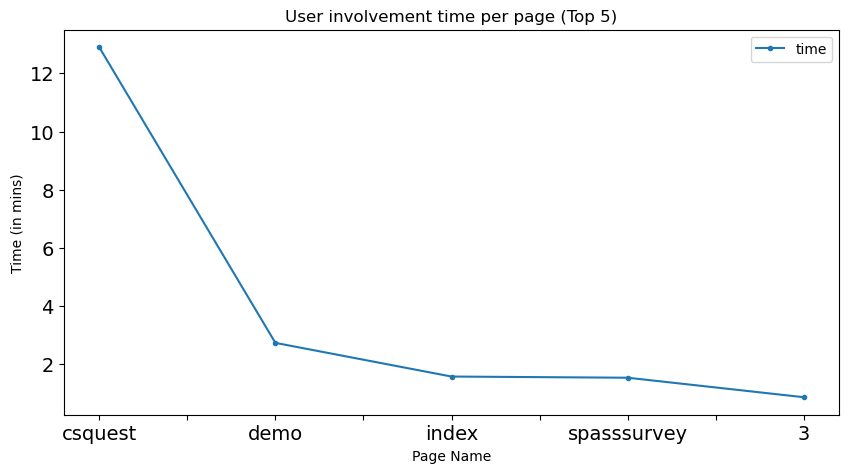

In [205]:
page_time_df = pd.DataFrame(time_response)
page_time_df = page_time_df.sort_index(axis=1, key=lambda x: x.astype(int))
page_time_df = page_time_df.rename(page_map, axis=1)
page_time_df['total (mins)'] = page_time_df.sum(axis=1)/60
display(page_time_df)
display(page_time_df['total (mins)'].mean())


# top 5 pages with higher time
top5 = pd.DataFrame(columns=['page', 'time'])
for i, data in page_time_df.median().div(60).sort_values(ascending=False).head(5).items():
    top5 = pd.concat([top5, pd.DataFrame([[i, data]], columns=top5.columns)])

_ = top5.plot(x='page', y='time', figsize=(10, 5), xlabel="Page Name", ylabel="Time (in mins)", title="User involvement time per page (Top 5)", fontsize=14, style=".-")

# Survey Response Analysis

In [206]:
questions = get_questions()
survey_response_df = pd.DataFrame(survey_response)
display(survey_response_df.head(1))

,8,9,0,10,null
0,"{'Sto': {'12-1': '2', '5-1': '6', '5-2': '5', ...","{'1-1': 'lrndsk!schl', '2-1': 'Strong', '3-1':...","{'1-1': ['Schoolwork', 'Assignments and homewo...","{'1-1': 'Boy', '2-1': '11 years old', '3-1': '...",NaN


In [207]:
# Function to filter data based on page number
def test(d):
    temp = {}
    for k, v in d.items():
        if (k != 'design_order'):
            for k2, v2 in v.items():
                q = f'{k2}_{k}'
                temp[q] = v2
    return temp

## CSQuest

In [208]:
csq_pid = '8'
design_order_series = survey_response_df[csq_pid].apply(lambda x: x.get('design_order'))
csquest_response_df = survey_response_df[csq_pid].apply(test)
csquest_questions = get_questions().get(csq_pid)

csquest_response_df = pd.DataFrame(csquest_response_df.to_dict()).T
csquest_response_df.head(1)

,12-1_Sto,5-1_Sto,5-2_Sto,5-3_Sto,5-4_Sto,9-1_Sto,10-1_Sto,2-1_Sto,3-1_Sto,6-1_Sto,...,1-2_Bas,1-4_Bas,13-1_Sto,8-1_Sto,11-1_Sto,4-1_Sto,11-1_Cus,8-1_Cus,4-1_Cus,13-1_Cus
0,2,6,5,7,6,5,7,4,5,5,...,6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
qualqsid = ['4-1', '8-1', '11-1', '12-1', '13-1']
quantqsid = ['1-1', '1-2', '1-3', '1-4', '2-1', '3-1', '5-1', '5-2', '5-3', '5-4', '6-1', '7-1', '9-1', '10-1']
dnames = ['Sto', 'Cus', 'Bas']

qualcolumns = [f'{qsid}_{dname}' for qsid in qualqsid for dname in dnames]
quantcolumns = [f'{qsid}_{dname}' for qsid in quantqsid for dname in dnames]

### Qualitative Analysis/Export

In [210]:
qualcolumns_filtered = list(set(csquest_response_df.columns).intersection(qualcolumns))
csquest_qual_df = csquest_response_df[qualcolumns_filtered]
csquest_qual_df.head()

,11-1_Cus,12-1_Sto,13-1_Sto,13-1_Cus,11-1_Sto,4-1_Sto,8-1_Sto,8-1_Cus,4-1_Cus,8-1_Bas,12-1_Cus,4-1_Bas,13-1_Bas,12-1_Bas,11-1_Bas
0,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Because I do not want my computer hacked and r...,3,1st design it is something no one will likely ...,1st:it is a random memory and no one will gues...,1,3rd design because it shows how in different s...
1,NaN,2,The second one is the best because it shows ho...,NaN,Second one cause it shows the steps on how to ...,The first one is the best one for capturing my...,Probably the first one cause that could happen...,NaN,NaN,NaN,3,NaN,NaN,1,NaN
2,I think the first one is helping you because i...,3,NaN,That design was my first choice because it hel...,NaN,NaN,NaN,Second design because it tells you that 80% of...,I think the first one because it like gives yo...,NaN,1,NaN,NaN,2,NaN
3,NaN,3,I liked the last design more because it was ea...,NaN,The last one because I understand it better.,I like the last one.,The last one.,NaN,NaN,NaN,1,NaN,NaN,2,NaN
4,NaN,2,I liked that design the most because it had le...,NaN,I think it was easy to understand the second o...,The first one because it showed a lot of like ...,The first one because it has this picture of a...,NaN,NaN,NaN,3,NaN,NaN,1,NaN


In [211]:
prefixes = set(col.split('_')[0] for col in csquest_qual_df.columns)
# Combine columns based on the common prefixes
for prefix in prefixes:
    if (prefix != '12-1'):
        matching_columns = [col for col in csquest_qual_df.columns if col.startswith(prefix)]
        combined_column_name = prefix.split('-')[0]
        csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        csquest_qual_df = csquest_qual_df.drop(columns=matching_columns)
    else:
        matching_columns = [col for col in csquest_qual_df.columns if col.startswith(prefix)]
        combined_column_name = prefix.split('-')[0]
        csquest_qual_df[combined_column_name] = ''
        for matching_column in matching_columns:
            csquest_qual_df[combined_column_name] += '_' + csquest_qual_df[matching_column] + f"({matching_column.split('_')[1]})"
        csquest_qual_df = csquest_qual_df.drop(columns=matching_columns)



# Function to remove nan_ from the beginning and _nan from the end
def remove_prefix_suffix(value):
    if pd.notna(value):
        value = str(value)
        value = value.replace('_nan', '')
        value = value.replace('nan_', '')
        value = value.strip('_')
    return value

# Apply the function to each element in the DataFrame
csquest_qual_df = csquest_qual_df.applymap(remove_prefix_suffix)

new_columns = [get_qinfo(csq_pid, c) for c in csquest_qual_df.columns]
csquest_qual_df.columns = new_columns
csquest_qual_df['Design Order'] = design_order_series
csquest_qual_df.to_csv('data/qualitative/csquest.csv', index=False)

/tmp/ipykernel_42040/381797151.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  csquest_qual_df[combined_column_name] = csquest_qual_df[matching_columns].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


### Quantitative Analysis

In [212]:
csquest_quant_df = csquest_response_df[quantcolumns].astype(int)
norm_csquest_quant_df = csquest_quant_df.sub(4)
norm_csquest_quant_df.head(1)

,1-1_Sto,1-1_Cus,1-1_Bas,1-2_Sto,1-2_Cus,1-2_Bas,1-3_Sto,1-3_Cus,1-3_Bas,1-4_Sto,...,6-1_Bas,7-1_Sto,7-1_Cus,7-1_Bas,9-1_Sto,9-1_Cus,9-1_Bas,10-1_Sto,10-1_Cus,10-1_Bas
0,2,0,1,1,0,2,-1,1,0,3,...,1,3,3,3,1,1,1,3,3,3


In [213]:
norm_sto_df = norm_csquest_quant_df.filter(like='Sto')
norm_cus_df = norm_csquest_quant_df.filter(like='Cus')
norm_bas_df = norm_csquest_quant_df.filter(like='Bas')

In [214]:
condition = '1-|5-'
new_norm_sto_df = norm_sto_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

temp = norm_sto_df.filter(like='1-')
new_norm_sto_df['1'] = temp.T.mean()

temp = norm_sto_df.filter(like='5-')
new_norm_sto_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_sto_df.columns}
new_norm_sto_df = new_norm_sto_df.rename(columns=new_column_names)

display(new_norm_sto_df)


condition = '1-|5-'
new_norm_cus_df = norm_cus_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

temp = norm_cus_df.filter(like='1-')
new_norm_cus_df['1'] = temp.T.mean()

temp = norm_cus_df.filter(like='5-')
new_norm_cus_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_cus_df.columns}
new_norm_cus_df = new_norm_cus_df.rename(columns=new_column_names)

display(new_norm_cus_df)


condition = '1-|5-'
new_norm_bas_df = norm_bas_df.filter(regex=f'^(?!.*{condition}).*$', axis=1)

new_column_names = {old_name: old_name.split('-')[0] for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

temp = norm_bas_df.filter(like='1-')
new_norm_bas_df['1'] = temp.T.mean()

temp = norm_bas_df.filter(like='5-')
new_norm_bas_df['5'] = temp.T.mean()
new_column_names = {old_name: get_qinfo(csq_pid, old_name) for old_name in new_norm_bas_df.columns}
new_norm_bas_df = new_norm_bas_df.rename(columns=new_column_names)

display(new_norm_bas_df)
# display(new_norm_bas_df.avg())

# test = new_norm_bas_df.mean(axis=0)
# display(test)



,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,0,1,1,3,1,3,1.25,2.00
1,3,1,3,3,3,-2,-1.50,-2.25
2,2,2,2,3,3,2,0.00,2.00
3,2,2,3,2,3,2,2.25,3.00
4,3,1,1,3,2,2,0.50,2.50
5,1,1,3,3,3,3,2.00,2.25
6,-2,2,3,2,3,3,1.00,0.00
7,0,1,3,3,3,3,0.25,2.75
8,3,3,2,1,2,2,2.00,2.25
9,2,1,3,2,3,2,0.50,1.25


,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,1,0,1,3,1,3,0.75,2.00
1,0,0,0,1,0,1,0.50,0.75
2,2,2,1,1,3,2,3.00,1.75
3,3,3,3,3,3,3,1.75,3.00
4,0,0,1,2,1,2,0.25,1.25
5,2,2,1,2,2,2,2.00,1.75
6,2,3,-3,2,3,2,2.25,2.50
7,1,3,-3,0,2,2,1.75,2.75
8,2,2,1,0,2,1,1.50,2.00
9,2,3,2,3,3,3,2.00,2.25


,Attention,Engaging,Awareness,Motivation,Understandability,Skills,Aesthetics,Usefulness
0,0,1,1,3,1,3,1.50,2.00
1,1,2,0,2,2,3,0.75,1.50
2,2,2,1,1,3,2,1.00,2.00
3,3,2,2,2,3,2,2.75,2.75
4,1,0,1,2,3,1,1.00,1.75
5,2,2,1,2,3,3,2.50,2.00
6,2,3,-3,2,3,3,2.50,3.00
7,0,0,-3,1,2,1,2.50,2.50
8,1,2,1,1,1,1,1.25,1.75
9,2,2,1,3,3,1,2.25,2.00


In [215]:
def stats(df, title='Main Title'):
    # Set up subplots
    fig, axes = plt.subplots(nrows=len(df.select_dtypes(include='number').columns), ncols=4, figsize=(15, 2 * len(df.columns)))
    # Loop through numerical columns and plot distribution in subplots
    for i, column in enumerate(df.select_dtypes(include='number').columns):
        # Descriptive statistics
        axes[i, 0].set_title(f'Statistics of {column}')
        stats = df[column].describe()
        pd.DataFrame(stats).T.plot.box(ax=axes[i, 0])
        # Rotate x-axis labels at a 45-degree angle
        axes[i, 0].set_xticklabels(axes[i, 0].get_xticklabels(), rotation=45, ha='right')
        # print(f'Distribution for column {column}:\n{stats}\n')
        # stats.T.plot.box(vert=False)
        
        # Plot histogram
        df[column].plot(kind='hist', bins=10, edgecolor='black', ax=axes[i, 1])
        axes[i, 1].set_title(f'Histogram of {column}')
        axes[i, 1].set_xlabel(column)
        axes[i, 1].set_ylabel('Frequency')
        
        # Box plot
        df.boxplot(column=column, ax=axes[i, 2])
        axes[i, 2].set_title(f'Box Plot of {column}')
        
        # KDE plot
        df[column].plot(kind='kde', ax=axes[i, 3])
        axes[i, 3].set_title(f'KDE Plot of {column}')

    # Adjust layout
    plt.tight_layout()
    
    # Add a title at the top of the figure with some margin below
    # plt.suptitle(title, y=0.95, fontsize=16)
    plt.show()

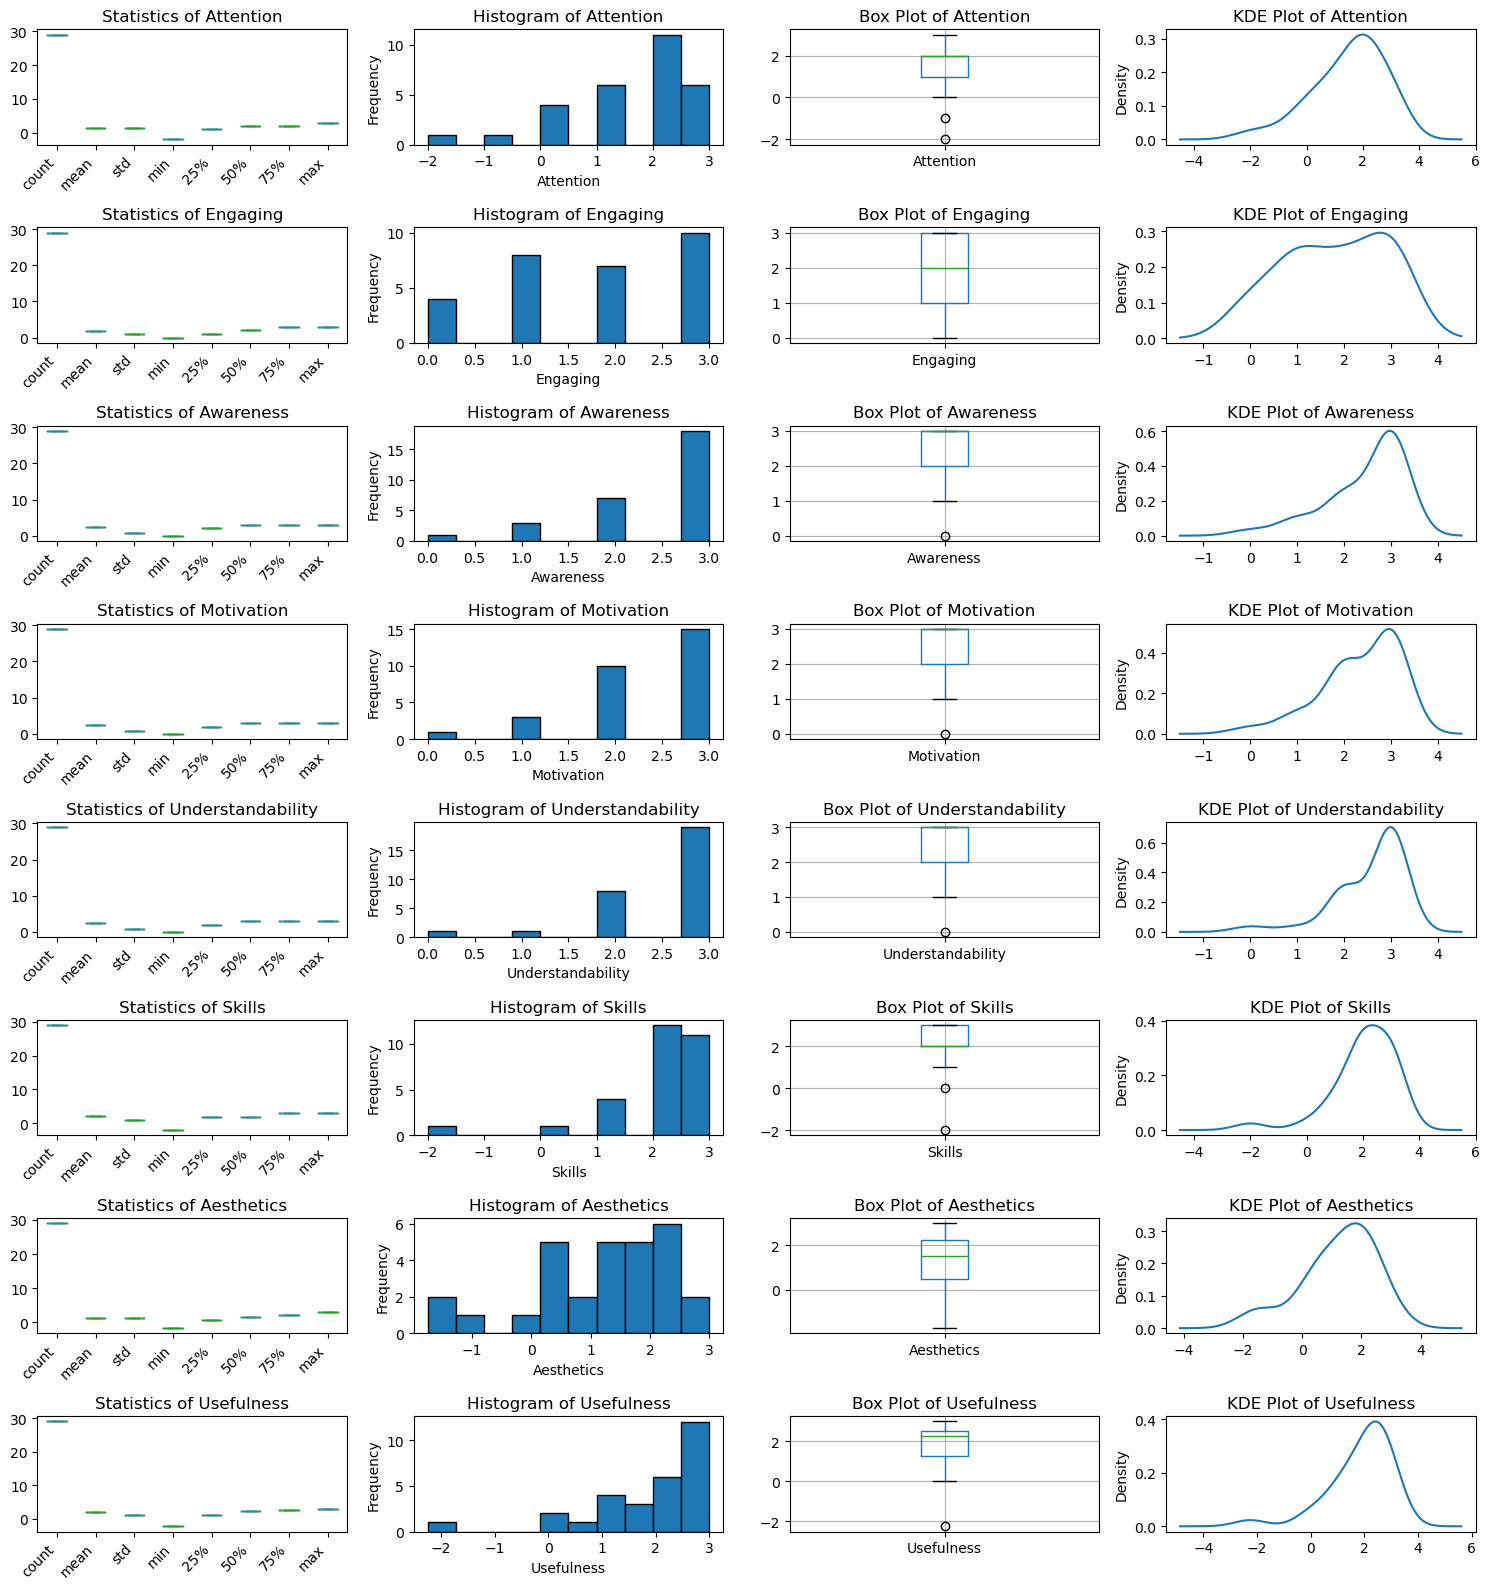

In [216]:
stats(new_norm_sto_df, 'Story')

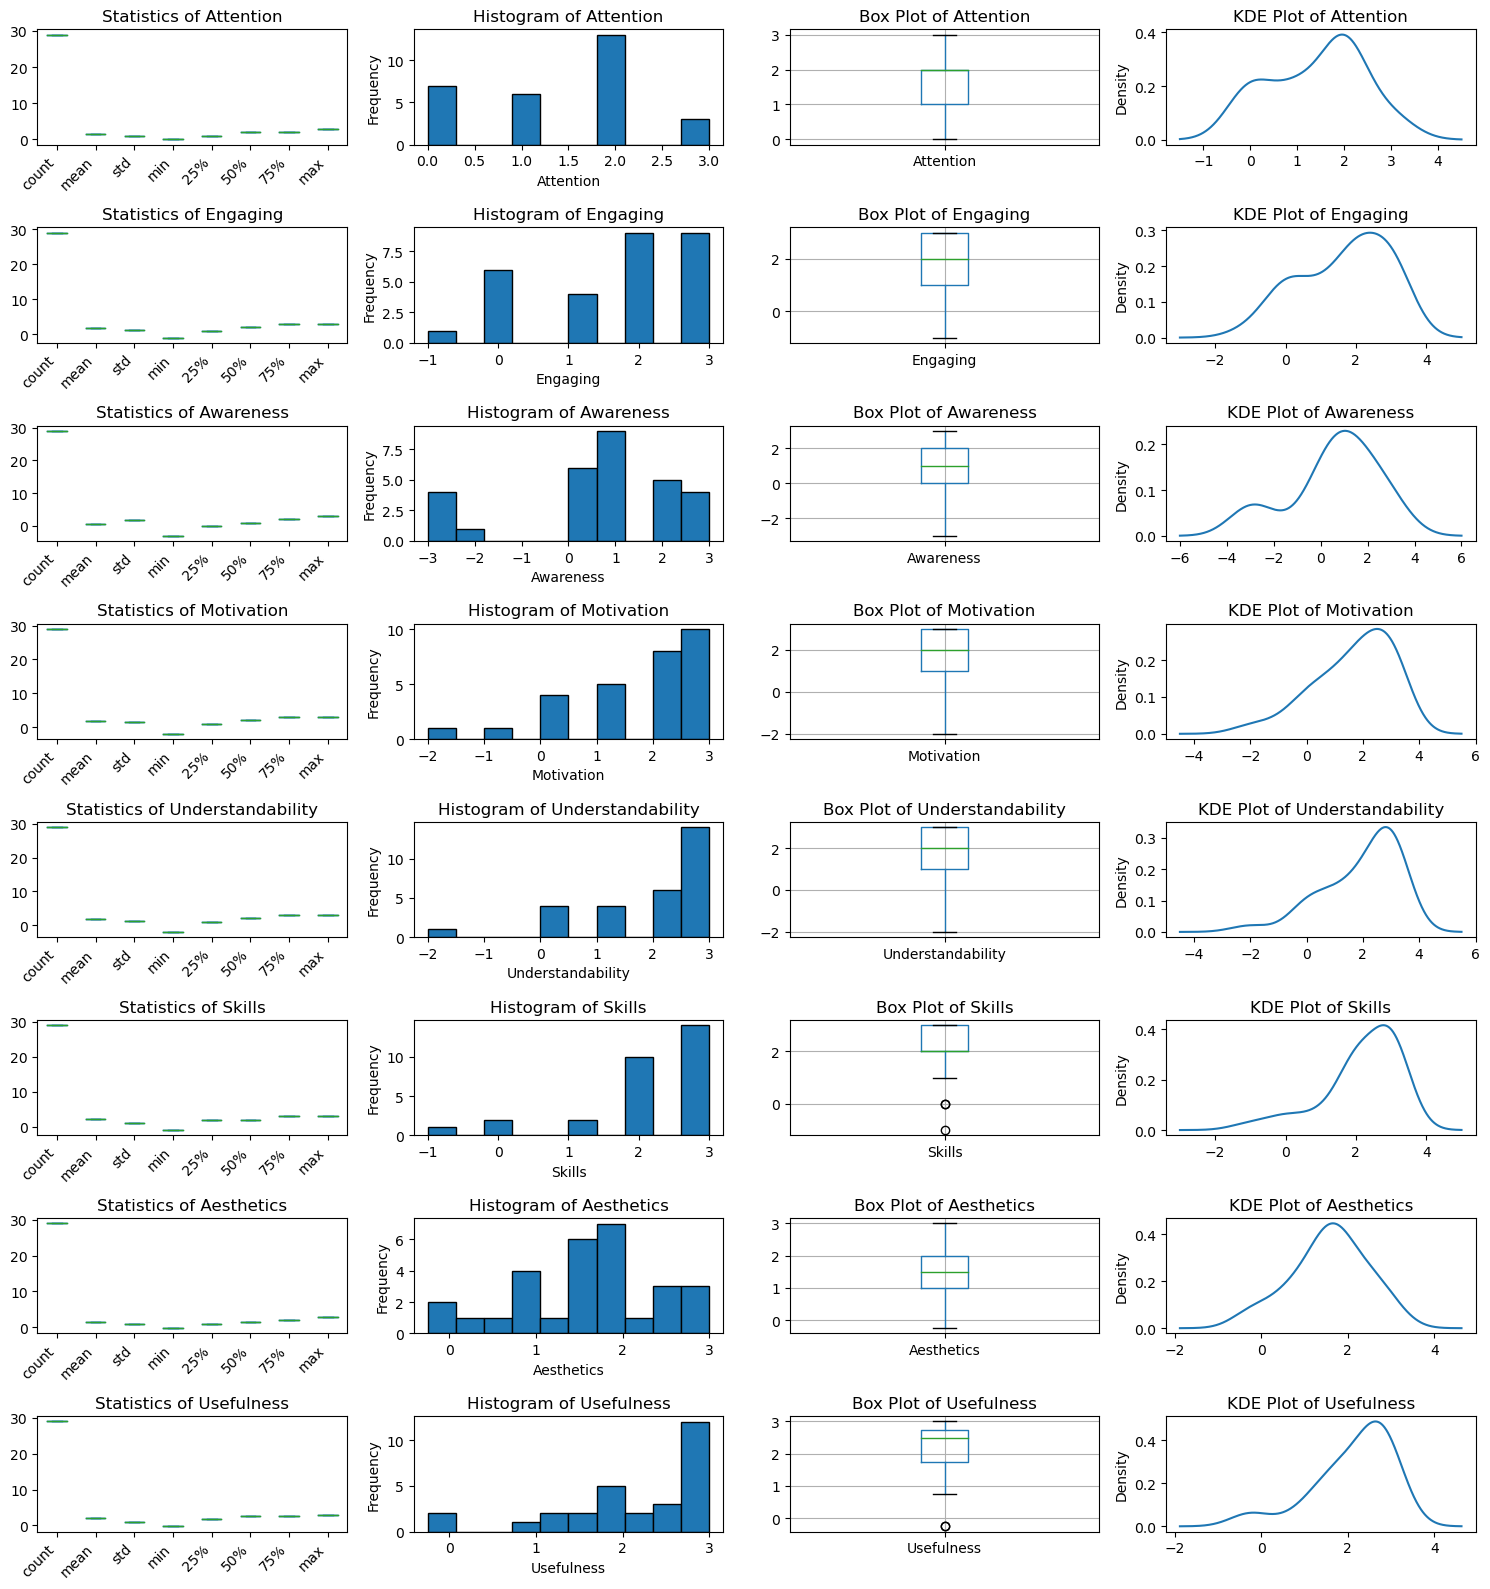

In [217]:
stats(new_norm_cus_df, 'Custom')

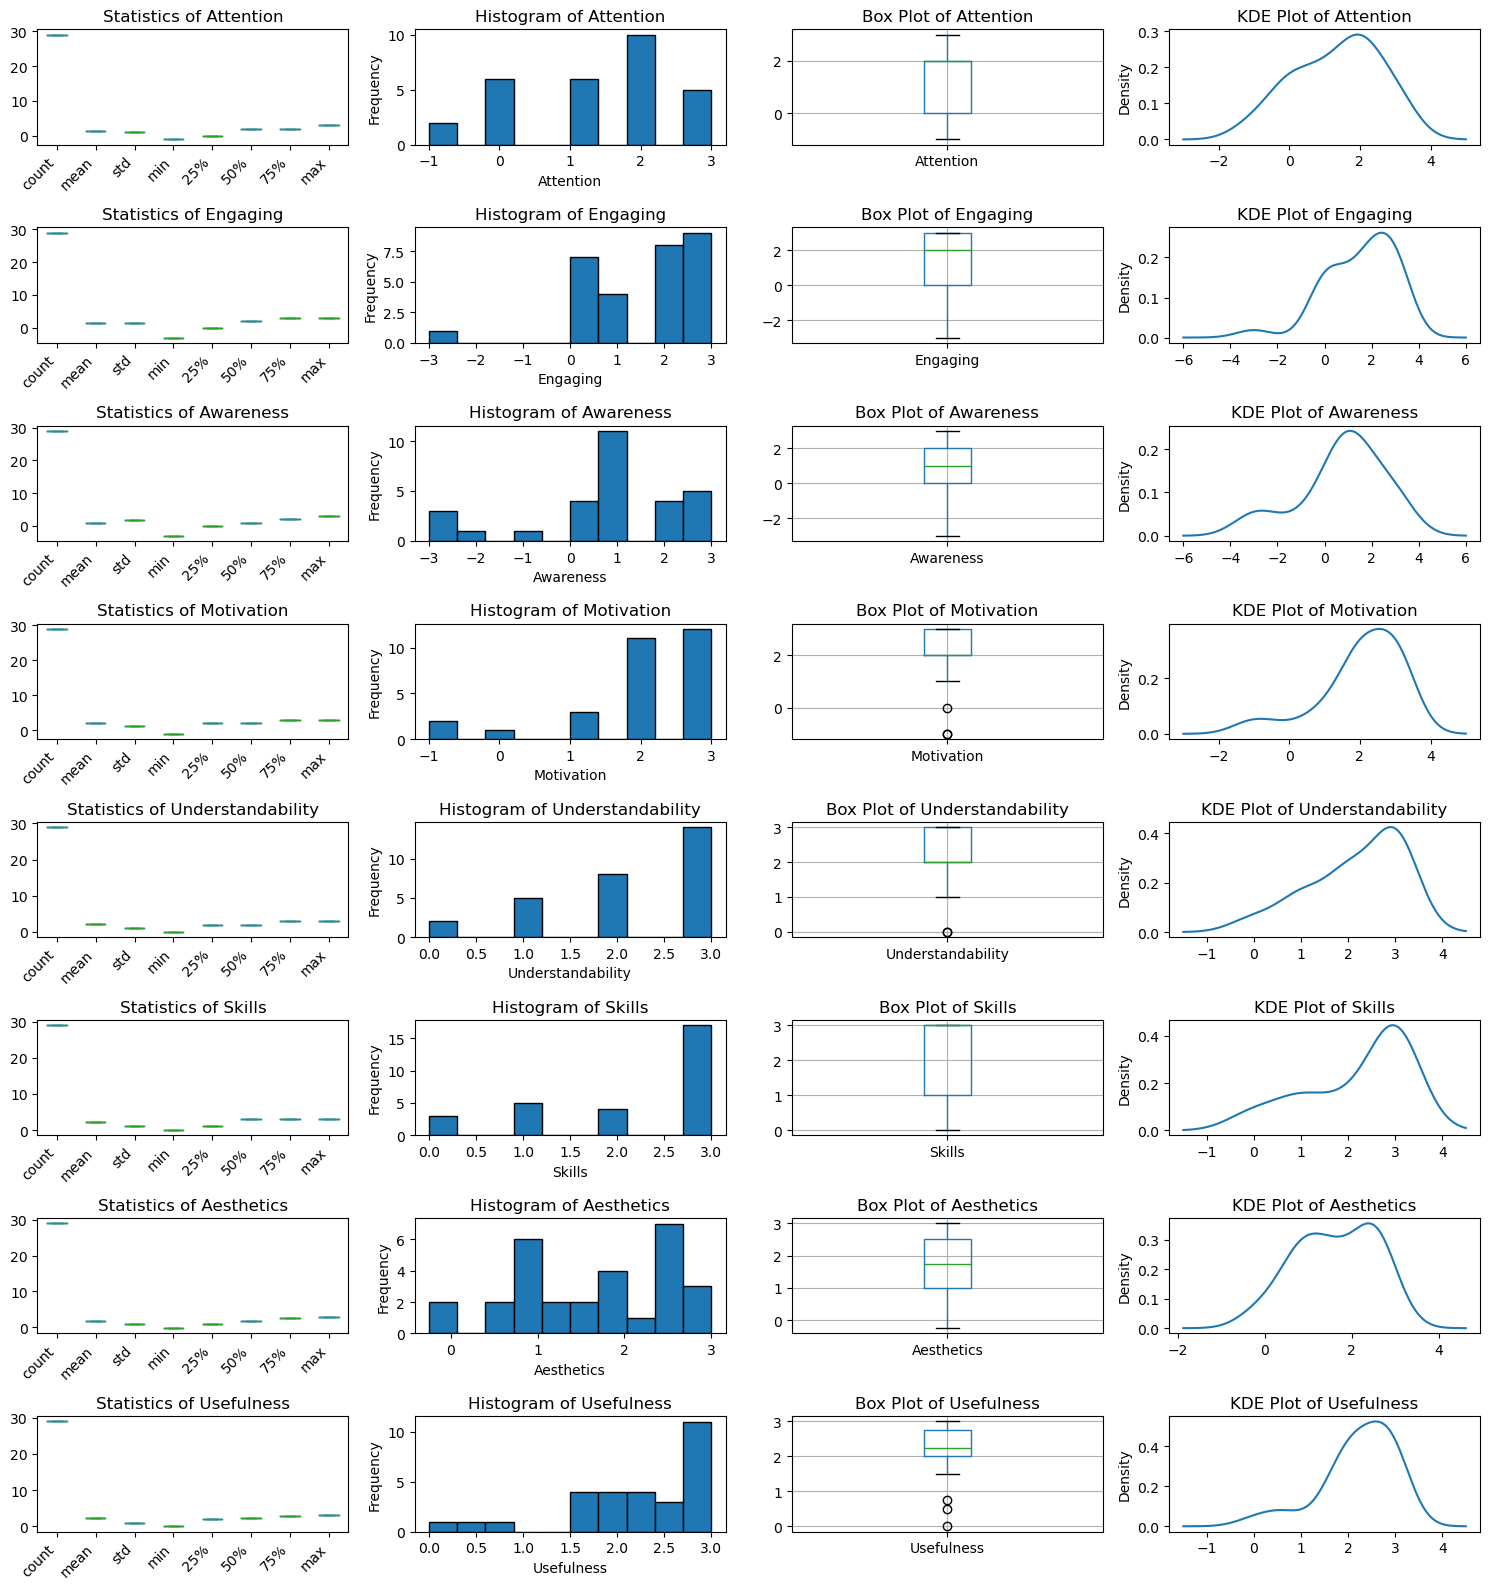

In [218]:
stats(new_norm_bas_df, 'Baseline')

In [219]:
sto_mean = pd.DataFrame(new_norm_sto_df.mean()).T
cus_mean = pd.DataFrame(new_norm_cus_df.mean()).T
bas_mean = pd.DataFrame(new_norm_bas_df.mean()).T

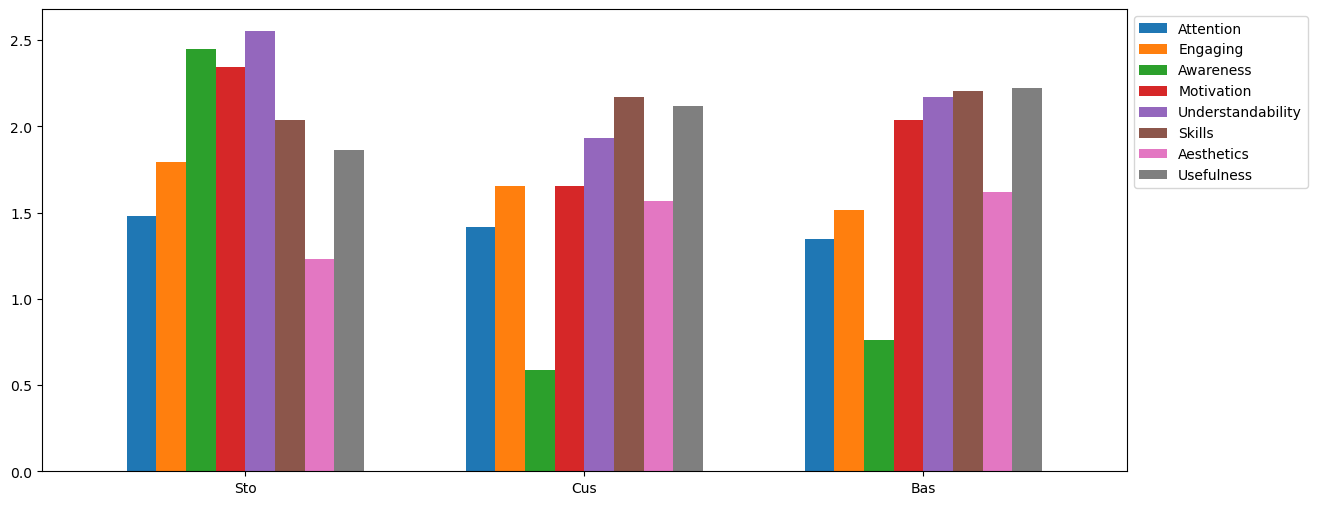

In [220]:
combined_df = pd.concat([sto_mean, cus_mean, bas_mean], ignore_index=True)
ax = combined_df.plot.bar(width=0.7, figsize=(14, 6))
_ = ax.set_xticklabels(dnames, rotation=0)
_ = ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
# _ = ax.annotate((y_value, "x_position" , "y_position"))